In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import vector

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Classical GAN

The goal of this notebook is to explore the possibility to use a GAN to generate jet images. The dataset used is the same as in the [Energy Energy Correlation](partonshower.ipynb) calculations, and will be used to generate a synthetic distribution of particle jets. The EEC calculation is then used to assess the quality of the physics model captured by this model.

## Table of Contents
1. [Data](##data)
2. [Model](##model)
3. [Training](##training)
4. [Results](##results)
5. [latent space](##exploring latent space)
6. [EEC](##energy-energy correlation functions)

## Data

The data used will be the synthetic quark and gluon data used in the previous example. Charged components only are used, and only the first 8 components with an energy at least 5 GeV are used with the remaining components discarded or padded with zeros.

### define some parameters of the problem

Here we define some parameters of the problem. Some parameters are only valid if running a conditional GAN. Others will be used shortly when loading the data.

In [3]:
e = np.loadtxt("./PythiaMomenta.csv",delimiter=",")
e_split = np.split(e,len(e)/8)
events = np.stack(e_split)
print(events.shape)

(1000000, 8, 4)


(array([4.82000e+02, 1.36500e+03, 2.39400e+03, 3.26200e+03, 4.42500e+03,
        5.24000e+03, 6.46300e+03, 7.28400e+03, 8.32300e+03, 9.35400e+03,
        1.03830e+04, 1.13360e+04, 1.23220e+04, 1.34600e+04, 1.47570e+04,
        1.58380e+04, 1.73570e+04, 1.87950e+04, 2.04660e+04, 2.23910e+04,
        2.39400e+04, 2.65750e+04, 2.91470e+04, 3.21700e+04, 3.56890e+04,
        3.90930e+04, 4.35430e+04, 4.79910e+04, 5.38260e+04, 5.96960e+04,
        6.59140e+04, 7.30780e+04, 8.00160e+04, 8.76490e+04, 9.64420e+04,
        1.05391e+05, 1.14355e+05, 1.23434e+05, 1.33457e+05, 1.43476e+05,
        1.55364e+05, 1.66818e+05, 1.79580e+05, 1.94301e+05, 2.10011e+05,
        2.28086e+05, 2.44658e+05, 4.58642e+05, 3.02084e+05, 3.92424e+05,
        2.75833e+05, 2.62569e+05, 2.47227e+05, 3.03177e+05, 2.20248e+05,
        2.04174e+05, 1.89899e+05, 1.76275e+05, 1.63689e+05, 1.53365e+05,
        1.43426e+05, 1.33243e+05, 1.23945e+05, 1.14023e+05, 1.06068e+05,
        9.77040e+04, 9.00460e+04, 8.19840e+04, 7.46

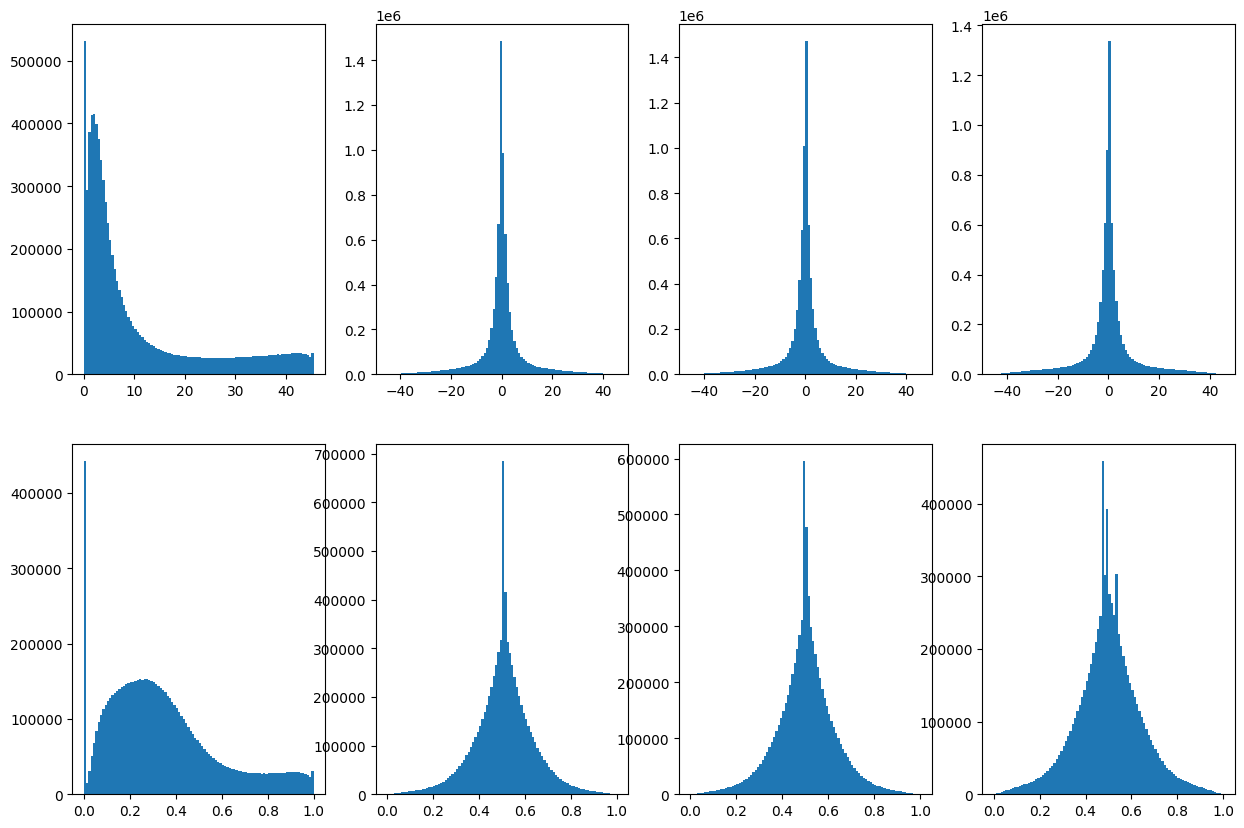

In [4]:
# explore to limits

fig,(ax1,ax2) = plt.subplots(2,4,figsize=(15,10))
ax1[0].hist(events[:,:,0].flatten(),bins=100)
ax1[1].hist(events[:,:,1].flatten(),bins=100)
ax1[2].hist(events[:,:,2].flatten(),bins=100)
ax1[3].hist(events[:,:,3].flatten(),bins=100)
# normalise all 8 x 3 features with MinMaxScaler

scalers = np.zeros((8,4),dtype=object)
for i in range(8):
    for j in range(4):
        scalers[i,j] = MinMaxScaler().fit(events[:,i,j].reshape(-1,1))
        events[:,i,j] = scalers[i,j].transform(events[:,i,j].reshape(-1,1)).flatten()

ax2[0].hist(events[:,:,0].flatten(),bins=100)
ax2[1].hist(events[:,:,1].flatten(),bins=100)
ax2[2].hist(events[:,:,2].flatten(),bins=100)
ax2[3].hist(events[:,:,3].flatten(),bins=100)



make training and test sets

## Full Range EEC

In [5]:
events.shape

(1000000, 8, 4)

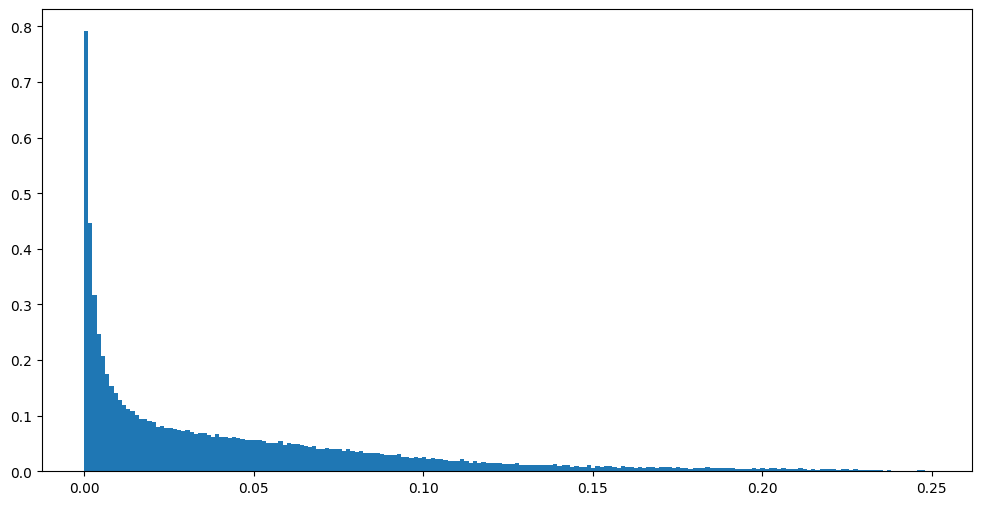

In [9]:
ECM = 91.0

def dot(q1,q2):
    y = q1[1]*q2[1]+q1[2]*q2[2]+q1[3]*q2[3]
    return y

def z_angle(p1,p2):
    if dot(p1,p1)==0.0 or dot(p2,p2) == 0:
        cos_phi = 1.0
    else:
        cos_phi = dot(p1,p2)/(np.sqrt(dot(p1,p1))*np.sqrt(dot(p2,p2)))
    z = (1.0-cos_phi)/2.0    
    return z
    

def EEC(lst):
    EEC_list = []
    for i in range(lst.shape[0]):
        for j in range(lst.shape[1]):
            for k in range(lst.shape[1]):
                if j!=k:
                    z = z_angle(lst[i,j],lst[i,k])
                    w = lst[i,j,0]*lst[i,k,0]/((ECM**2.0))
                    EEC_list.append((z,w))
    return EEC_list

Real_EEC = EEC(events[:10000])
real_angles = [item[0] for item in Real_EEC]
real_weights = [item[1] for item in Real_EEC]


    
            



fig,ax = plt.subplots(figsize=(12,6))


ax.hist(real_angles,bins=200,weights = real_weights)
plt.show()

## Invariant Mass Squared

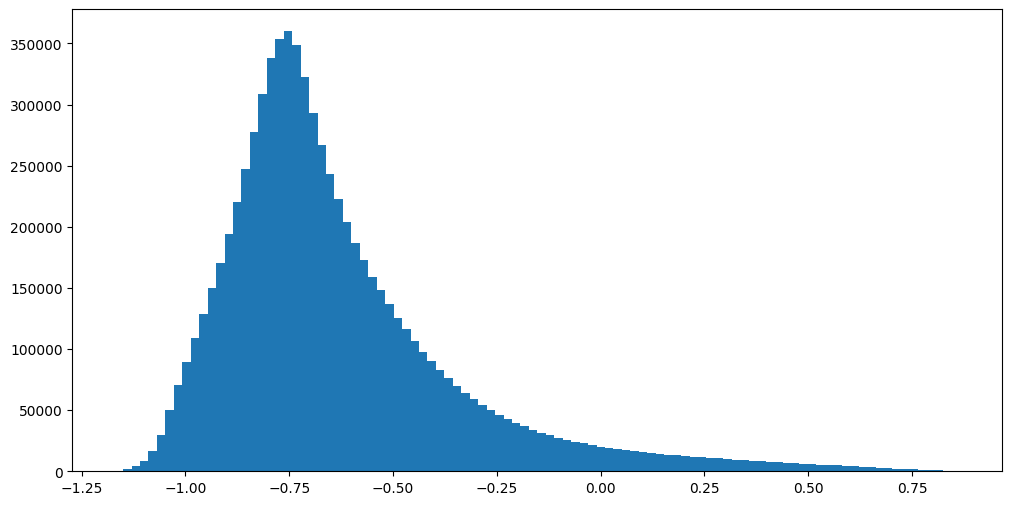

In [11]:
def m2(h):
    m2 = []
    for event in h:
        for particle in event:
            if particle[0]!=0.0 and particle[1]!=0.0 and particle[2]!=0.0 and particle[3]!=0.0:
                mass2 = particle[0]**2 - (particle[1]**2 + particle[2]**2 + particle[3]**2)
                m2.append(mass2)

    return m2

masses_real = m2(events)
#masses_gen = m2(gan_events_unscaled) 
#scaled_masses_real = m2(events_scaled)
#scaled_masses_gen = m2(gan_events_scaled)

fig,ax = plt.subplots(figsize=(12,6))


ax.hist(masses_real,bins=100)
plt.show()


In [13]:
def two_point_correlator(event, n_bins=75):
    # event is a 2d array of shape (n,4) where n is the number of particles
    # the columns are (pt, eta, phi, charge) *note that charge is not used here
    n = event.shape[0]
    # we will store the result in a 2d array of shape (n,n)
    result = np.zeros((n,n))
    weights = np.zeros((n,n))
    # calculate the total energy in the event
    event_energy = event[:,0].sum()
    for i in range(n):
        for j in range(n):
            # calculate the angle between the particles
            d_eta = event[i,1] - event[j,1]
            d_phi = event[i,2] - event[j,2]
            dR = np.sqrt(d_eta**2 + d_phi**2)
            result[i,j] = dR
            # calculate the weight
            fractioni = event[i,0]/event_energy
            fractionj = event[j,0]/event_energy
            weights[i,j] = fractioni*fractionj
    bins = np.logspace(-3,0,n_bins+1)
    bin_widths = bins[1:] - bins[:-1]
    # get the weights outside the bin range
    self_weights = 0
    for r in range(result.flatten().shape[0]):
        if result.flatten()[r] < bins[0]:
            self_weights += weights.flatten()[r]
    #self_weights += np.sum(np.where(result > bins[-1], 0, weights))
    #concatenate the weights as the first bin
    return np.concatenate([[self_weights],np.histogram(result.flatten(), bins=bins, weights=weights.flatten())[0]])

In [42]:
# use vector 4 vector library to convert e, px, py, pz to pt, eta, phi, m

def convert_4_vectors(events):
    # first we convert the events into a structured array of 4 vectors [:,8,structured_array]
    structured_events = vector.array(
        events,
        dtype=[("e", float), ("px", float), ("py", float), ("pz", float)],
    )

In [80]:
print(np.arange(0, 24, 0.1).shape,np.arange(0, 24, 0.1).view([("x", float),("y", float),("z", float),("t", float)] ).shape)
first_event = events[0]
print(first_event.shape)
# let's convert the first event to vector event so only 8 of them
structured_event = first_event.view([("e", float), ("px", float), ("py", float), ("pz", float)]).view(vector.MomentumNumpy4D)

print(structured_event.shape)
print([structured_event[i].pt for i in range(8)])

(240,) (60,)
(8, 4)
(8, 1)
[array([18.59842044]), array([18.37562607]), array([10.76738224]), array([9.13258623]), array([1.62468553]), array([1.56193985]), array([0.22864044]), array([0.23264569])]


In [85]:
# convert all events to vector events
structured_events = events.view([("e", float), ("px", float), ("py", float), ("pz", float)]).view(vector.MomentumNumpy4D)
print(structured_events.shape)
print([structured_events[0,i].pt for i in range(8)])

(1000000, 8, 1)
[array([18.59842044]), array([18.37562607]), array([10.76738224]), array([9.13258623]), array([1.62468553]), array([1.56193985]), array([0.22864044]), array([0.23264569])]


In [90]:
# ok last thing get events in shape (n,8,4) where the 4 is (pt, eta, phi, m)
events_pepm = np.zeros_like(events)
events_pepm[:,:,0] = structured_events[:,:,0].pt
events_pepm[:,:,1] = structured_events[:,:,0].eta
events_pepm[:,:,2] = structured_events[:,:,0].phi
events_pepm[:,:,3] = structured_events[:,:,0].mass
print(events_pepm.shape)

(1000000, 8, 4)


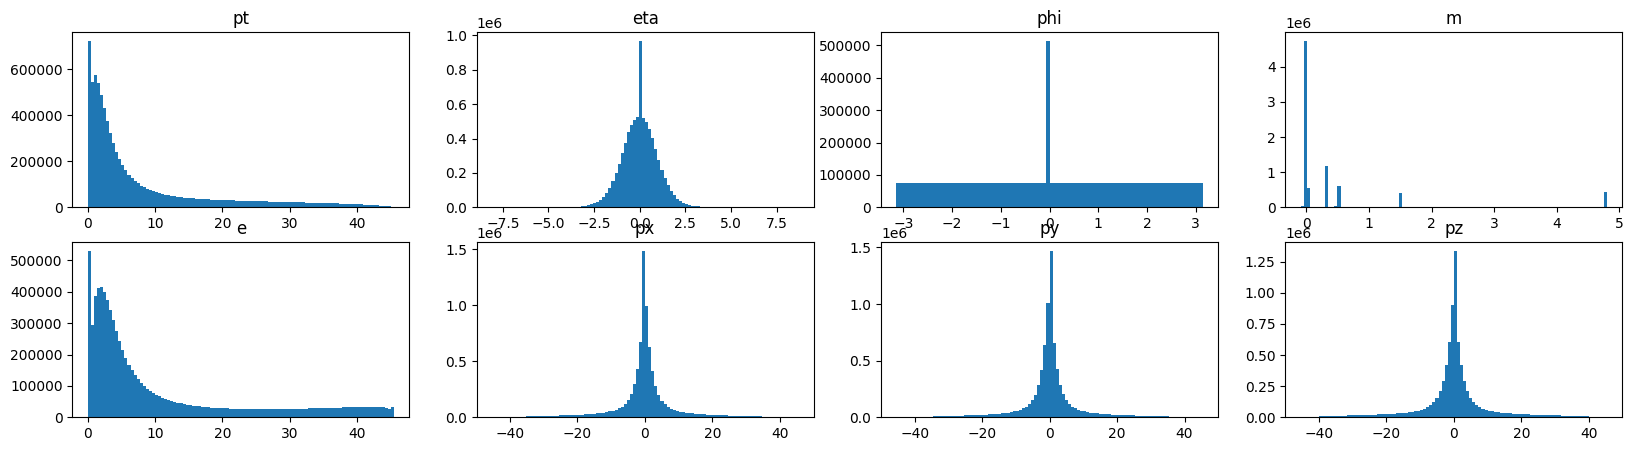

In [91]:
# plot e,px, py,pz 
# compared with pt, eta, phi, m
fig, (axs,bxs) = plt.subplots(2, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist(events_pepm[:,:,i].flatten(), bins=100)
    ax.set_title(['pt', 'eta', 'phi', 'm'][i])
for i, bx in enumerate(bxs):
    bx.hist(events[:,:,i].flatten(), bins=100)
    bx.set_title(['e', 'px', 'py', 'pz'][i])

In [92]:
tpc_hists = np.array([two_point_correlator(e) for e in events_pepm])
tpc_prob = tpc_hists.sum(axis=0)
# error sqrt of the sum of the squares
tpc_err = np.sqrt(np.sum(tpc_hists**2, axis=0))
tpc_err = tpc_err/tpc_prob.sum()
tpc_prob = tpc_prob/tpc_prob.sum()

tpc_prob = tpc_prob[1:] # chop off the self correlation
tpc_err = tpc_err[1:]
print(tpc_prob.shape)
bins = np.logspace(-3,0,75+1)
binwidths = np.log(bins[1:]) - np.log(bins[:-1])
midbins = (np.log(bins[1:]) + np.log(bins[:-1]))/2

(75,)


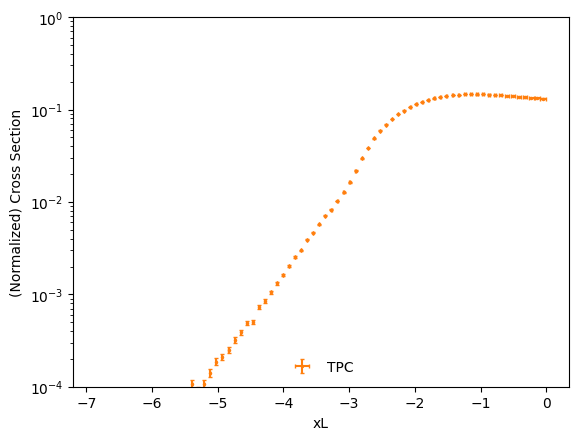

In [94]:
colors = {2: 'tab:blue', 3: 'tab:green', 4: 'tab:red'}
errorbar_opts = {
   'fmt': 'o',
   'lw': 1.5,
   'capsize': 1.5,
   'capthick': 1,
   'markersize': 1.5,
}
plt.errorbar(midbins, tpc_prob/binwidths,
             xerr=(bins[1:] - bins[:-1])/2,
             yerr=tpc_err/binwidths,
             color='tab:orange',
             label='TPC',
             **errorbar_opts)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-3, 1)
plt.ylim(1e-4, 1)
plt.xlabel('xL')
plt.ylabel('(Normalized) Cross Section')
plt.legend(loc='lower center', frameon=False)
plt.savefig('tpc.png');